Solve 
$$ \begin{eqnarray} && u_t + v u_x = 0, \quad x \in (0,1),\quad t\in (0,T], \\
     && u(x,0) = I(x), \quad x\in (0,1),\\
     && u(0,t) = u(1,t),\quad t\in (0,T],
\end{eqnarray}$$  
on $[0,1]$ with periodic boundary conditions and
an exponential initial condition, using the following methods:

- Explicit
- Lax-Wendroff
- Leapfrog
- Implicit
- Crank-Nicolson

Note that the simulation ends *before* the wave reaches the right-hand boundary. If this were not the case, the **exact** solution would need to be modified to account for the periodic reflection i.e. the wave after reaching the RH boundary, then enters from the LH boundary, etc. The numerical solution remains correct for all times.

This code is inspired from H.P. Langtangen's excellent book, "Finite Difference Computing with PDEs", Springer, 2017. The open acess version is available [here](https://link.springer.com/book/10.1007/978-3-319-55456-3). 


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def solver(I, U0, v, L, dt, C, T, 
           scheme='Explicit', periodic_bc=True):
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
    dx = v*dt/C
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)       # Mesh points in space
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    C = v*dt/dx
    print ('dt=%g, dx=%g, Nx=%d, C=%g, T=%g, Nt=%g' % (dt, dx, Nx, C, T, Nt))

    u   = np.zeros(Nx+1)
    u_n = np.zeros(Nx+1)
    u_nm1 = np.zeros(Nx+1)

    # Set initial condition u(x,0) = I(x)
    for i in range(0, Nx+1):
        u_n[i] = I(x[i])

    # Boundary condition
    u[0] = U0

    for n in range(0, Nt):
        if scheme == 'Explicit':
            if periodic_bc:
                i = 0
                u[i] = u_n[i] - 0.5*C*(u_n[i+1] - u_n[Nx])
                u[Nx] = u[0]
                #u[i] = u_n[i] - 0.5*C*(u_n[1] - u_n[Nx])
            for i in range(1, Nx):
                u[i] = u_n[i] - 0.5*C*(u_n[i+1] - u_n[i-1])
        elif scheme == 'LeapFrog':
            if n == 0:
                # Use upwind for first step
                if periodic_bc:
                    i = 0
                    #u[i] = u_n[i] - C*(u_n[i] - u_n[Nx-1])
                    u_n[i] = u_n[Nx]
                for i in range(1, Nx+1):
                    u[i] = u_n[i] - C*(u_n[i] - u_n[i-1])
            else:
                if periodic_bc:
                    i = 0
                    # Must have this,
                    u[i] = u_nm1[i] - C*(u_n[i+1] - u_n[Nx-1])
                    # not this:
                    #u_n[i] = u_n[Nx]
                for i in range(1, Nx):
                    u[i] = u_nm1[i] - C*(u_n[i+1] - u_n[i-1])
                if periodic_bc:
                    u[Nx] = u[0]
        elif scheme == 'Upwind':
            if periodic_bc:
                u_n[0] = u_n[Nx]
            for i in range(1, Nx+1):
                u[i] = u_n[i] - C*(u_n[i] - u_n[i-1])
        elif scheme == 'LW':
            if periodic_bc:
                i = 0
                # Must have this,
                u[i] = u_n[i] - 0.5*C*(u_n[i+1] - u_n[Nx-1]) + \
                       0.5*C*(u_n[i+1] - 2*u_n[i] + u_n[Nx-1])
                # not this:
                #u_n[i] = u_n[Nx]
            for i in range(1, Nx):
                u[i] = u_n[i] - 0.5*C*(u_n[i+1] - u_n[i-1]) + \
                       0.5*C*(u_n[i+1] - 2*u_n[i] + u_n[i-1])
            if periodic_bc:
                u[Nx] = u[0]
        else:
            raise ValueError('scheme="%s" not implemented' % scheme)

        if not periodic_bc:
            # Insert boundary condition
            u[0] = U0
            
        # Switch variables before next step
        u_nm1, u_n, u = u_n, u, u_nm1
        
    # output    
    plt.plot(x,u_n,x,uex(x,T))
    #plt.plot(x,u,x,u_n,x,u_nm1,x,uex(x,T))
    #plt.legend(['n+1','n','n-1','exact'])
    plt.legend(['numerical','exact'])
    plt.xlabel('x'); plt.ylabel('u(x;t=T)')
    # compute error at final time
    error = np.sqrt(dx*sum((uex(x,T)-u_n)**2))
    print ('Error for %s scheme = %g' % (scheme, error))

def solver_theta(I, v, L, dt, C, T, theta=0.5):
    """
    Solver with theta-rule
    difference approximation in time (no restriction on
    the time step when theta >= 0.5).
    Vectorized implementation and sparse (tridiagonal)
    coefficient matrix.
    """
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
    dx = v*dt/C
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)       # Mesh points in space
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    C = v*dt/dx
    print ('dt=%g, dx=%g, Nx=%d, C=%g' % (dt, dx, Nx, C))

    u   = np.zeros(Nx+1)
    u_n = np.zeros(Nx+1)
    u_nm1 = np.zeros(Nx+1)
    integral = np.zeros(Nt+1)

    # Set initial condition u(x,0) = I(x)
    for i in range(0, Nx+1):
        u_n[i] = I(x[i])

    # Representation of sparse matrix and right-hand side
    diagonal = np.zeros(Nx+1)
    lower    = np.zeros(Nx)
    upper    = np.zeros(Nx)
    b        = np.zeros(Nx+1)

    # Precompute sparse matrix (scipy format)
    diagonal[:] = 1
    lower[:] = -0.5*theta*C
    upper[:] =  0.5*theta*C
    # Insert boundary conditions
    upper[0] = 0
    lower[-1] = 0

    diags = [0, -1, 1]
    import scipy.sparse
    import scipy.sparse.linalg
    A = scipy.sparse.diags(
        diagonals=[diagonal, lower, upper],
        offsets=[0, -1, 1], shape=(Nx+1, Nx+1),
        format='csr')

    # Time loop
    for n in range(0, Nt):
        b[1:-1] = u_n[1:-1] + 0.5*(1-theta)*C*(u_n[:-2] - u_n[2:])
        b[0] = u_n[Nx]; b[-1] = u_n[0]  # boundary conditions
        b[0] = 0; b[-1] = 0  # boundary conditions
        u[:] = scipy.sparse.linalg.spsolve(A, b)

        # Update u_n before next step
        u_n, u = u, u_n

    plt.plot(x,u_n,x,uex(x,T))
    plt.legend(['numerical','exact'])
    plt.xlabel('x'); plt.ylabel('u(x;t=T)')
    # compute error at final time
    error = np.sqrt(dx*sum((uex(x,T)-u_n)**2))
    if theta == 0.5:
        scheme = 'CN'
    elif theta == 1:
        scheme = 'Implicit'
    print ('Error for %s scheme = %g' % (scheme, error))

def uex(x,t):
    v = 1. # wave speed
    uex = I(x-v*t)
    return uex

def I(x):
    L = 1.0
    sigma = 0.02
    return np.exp(-0.5*((x-L/10)/sigma)**2)

def run(scheme='UP', case='gaussian', C=1, dt=0.01):
    """Main routine for all explicit and implicit solvers."""
    
    if case == 'gaussian':
        def I(x):
            return np.exp(-0.5*((x-L/10)/sigma)**2)
    elif case == 'cosinehat':
        def I(x):
            return np.cos(np.pi*5/L*(x - L/10)) \
                   if 0 < x < L/5 else 0

    L = 1.0
    sigma = 0.02
 
    U0 = 0  
    T = 0.7 # final time
    v = 1

    if scheme == 'CN':
        solver_theta(
            I, v, L, dt, C, T)
    elif scheme == 'Implicit':
        solver_theta(
            I, v, L, dt, C, T, theta=1 )
    else:
        solver(
            I=I, U0=U0, v=v, L=L, dt=dt, C=C, T=T,
            scheme=scheme)




dt=0.01, dx=0.01, Nx=100, C=1, T=0.7, Nt=70
Error for LW scheme = 2.70388e-08


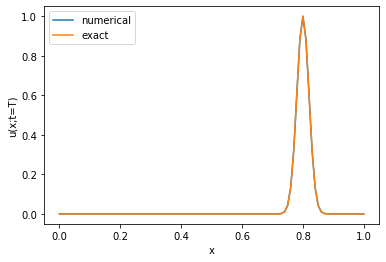

In [2]:
#run(scheme='Explicit', case='gaussian', C=1, dt=0.01)
#run(scheme='Upwind', case='gaussian', C=0.8, dt=0.01)
#run(scheme='LeapFrog', case='gaussian', C=0.8, dt=0.01)
#run(scheme='Implicit', case='gaussian', C=0.8, dt=0.01)
#run(scheme='CN', case='gaussian', C=1, dt=0.01)
run(scheme='LW', case='gaussian', C=1, dt=0.01)
